In [107]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the pre-weighted GML file
# This file is generated by the graph_creation.ipynb notebook
file_path = 'data/subway_graph_weekday_weekend_weights.gml'
G_weights = nx.read_gml(file_path)

# Display basic information about the graph
print(f"Graph loaded successfully from {file_path}")
print(f"Number of nodes: {G_weights.number_of_nodes()}")
print(f"Number of edges: {G_weights.number_of_edges()}")

Graph loaded successfully from data/subway_graph_weekday_weekend_weights.gml
Number of nodes: 395
Number of edges: 708


Graph loaded successfully from data/subway_graph_weekday_weekend_weights.gml
Number of nodes: 395
Number of edges: 708


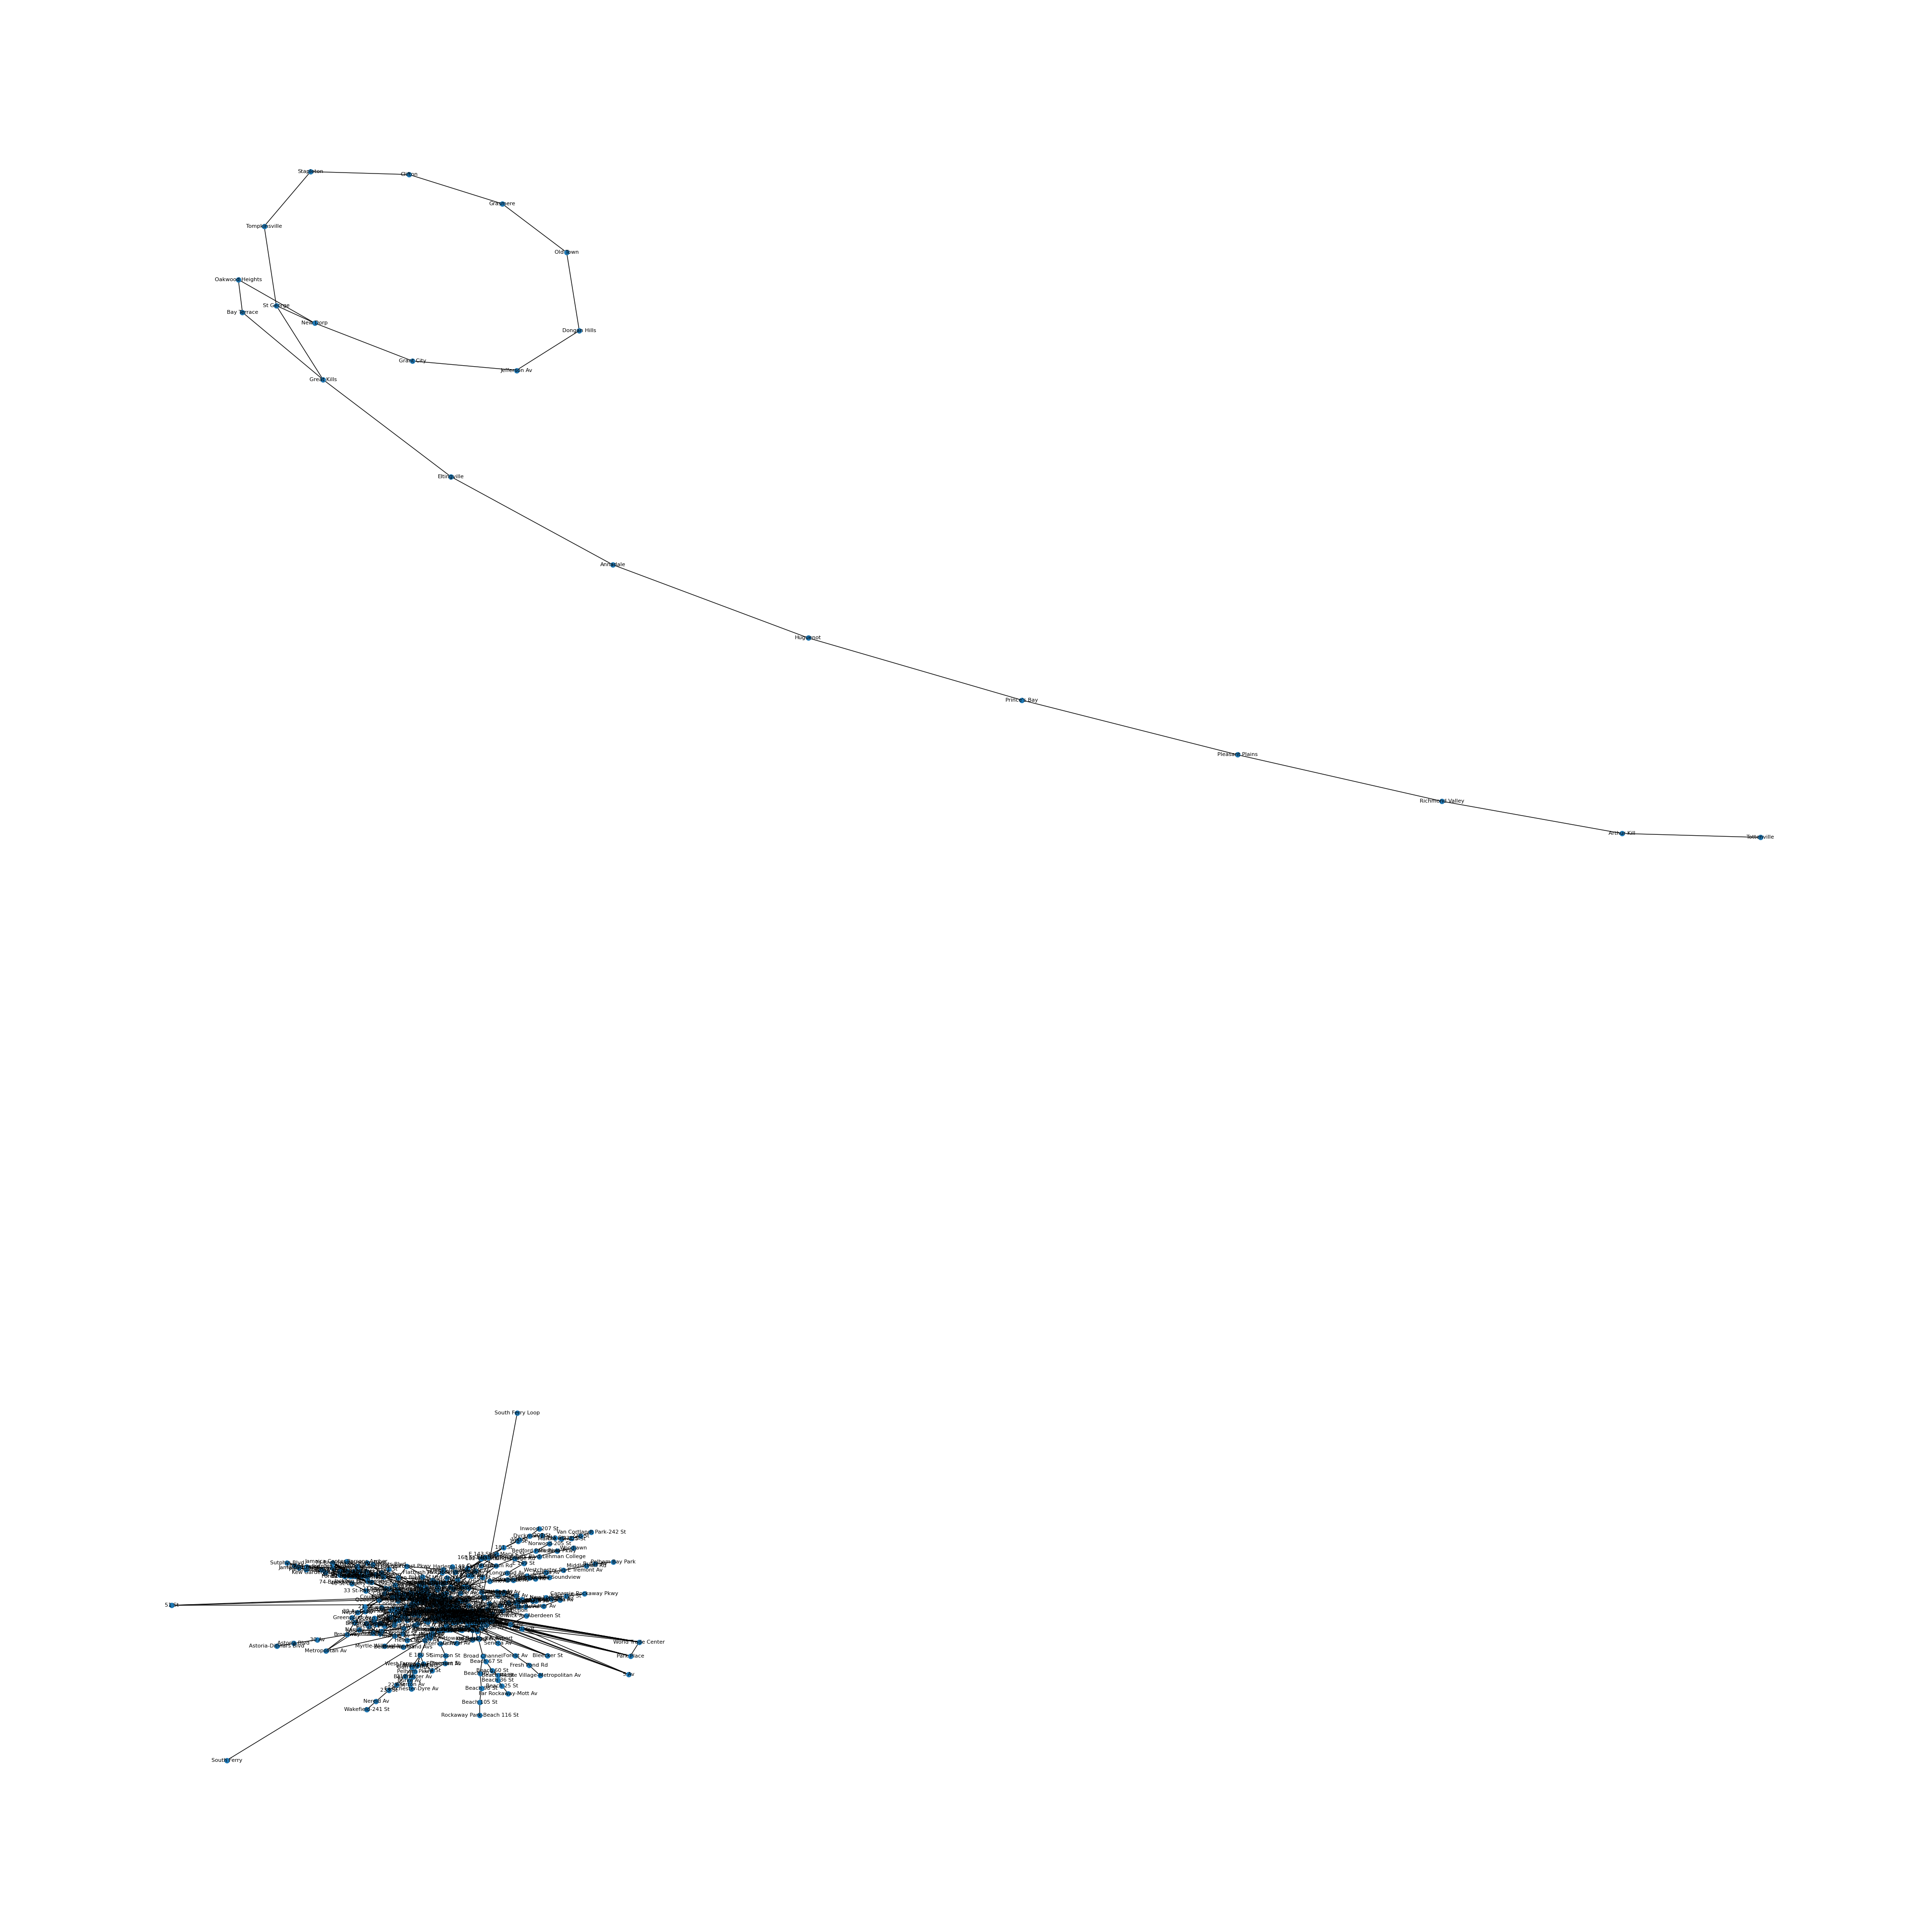

In [89]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the GML file
file_path = 'data/subway_graph_weekday_weekend_weights.gml'
G = nx.read_gml(file_path)

# Display basic information about the graph
print(f"Graph loaded successfully from {file_path}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Optional: Draw the graph (might be slow for large graphs)
plt.figure(figsize=(40, 40))
nx.draw(G, with_labels=True, node_size=50, font_size=8)

plt.savefig('subway_network_weekday_weekend.png', dpi=300)

plt.show()


In [90]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the GML file
# file_path = 'data/subway_graph_weekday_weekend.gml'
# G_weights = nx.read_gml(file_path)

# # Display basic information about the graph
# print(f"Graph loaded successfully from {file_path}")
# print(f"Number of nodes: {G_weights.number_of_nodes()}")
# print(f"Number of edges: {G_weights.number_of_edges()}")

# Optional: Draw the graph (might be slow for large graphs)
# plt.figure(figsize=(12, 12))
# nx.draw(G, with_labels=True, node_size=50, font_size=8)
# plt.show()

## Calculate PD

In [91]:
import pandas as pd
import networkx as nx

def calculate_proximity_density(G, cutoff, mode='hops'):
    """
    Calculates the normalized number of reachable nodes (Proximity Density) for each
    component of the graph separately, based on either hop count or travel distance.

    Args:
        G (nx.Graph): The input graph. It must have 'distance' attributes on edges if mode is 'distance'.
        cutoff (int or float): The maximum number of hops or travel distance (km) to consider.
        mode (str): The calculation mode. Can be 'hops' (default) or 'distance'.

    Returns:
        list: A list of pandas DataFrames, where each DataFrame contains the PD
              results for one connected component.
    """
    results_list = []

    if mode not in ['hops', 'distance']:
        raise ValueError("Mode must be either 'hops' or 'distance'.")

    unit_label = "km" if mode == 'distance' else "hops"
    
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for component in components:
        component_graph = G.subgraph(component).copy()
        total_nodes_in_component = component_graph.number_of_nodes()
        
        proximity_density = {}

        # Check for distance attribute if in distance mode
        if mode == 'distance' and not all('distance' in data for u, v, data in component_graph.edges(data=True)):
            print(f"Warning: Component is missing 'distance' attributes. Skipping distance calculation.")
            continue

        for node in component_graph.nodes():
            # --- THIS IS THE CORRECTED LOGIC ---
            if mode == 'hops':
                # Use the unweighted function for hop count
                distances = nx.single_source_shortest_path_length(component_graph, node, cutoff=cutoff)
            else: # mode == 'distance'
                # Use the Dijkstra algorithm for weighted paths
                distances = nx.single_source_dijkstra_path_length(component_graph, node, cutoff=cutoff, weight='distance')
            
            count = len(distances) - 1
            
            if total_nodes_in_component > 1:
                pd_value = count / (total_nodes_in_component - 1)
            else:
                pd_value = 0
            
            proximity_density[node] = pd_value

        # Create a pandas Series for the current component's results
        pd_series = pd.Series(proximity_density, name=f"PD_within_{cutoff}_{unit_label}")
        
        component_df = pd_series.to_frame()
        component_df = component_df.sort_values(by=f"PD_within_{cutoff}_{unit_label}", ascending=False)
        results_list.append(component_df)

    return results_list

In [92]:
# --- Example Usage for Hop-Based PD ---
hop_count = 5
component_pd_results = calculate_proximity_density(G_weights, cutoff=hop_count, mode='hops')

# Display the results for each component
for i, df in enumerate(component_pd_results):
    print(f"--- Proximity Density (PD) for Component {i+1} (Hops) ---")
    print(f"Analysis based on a hop limit of {hop_count} stops:")
    print(df.head(10))  # Displaying the top 10 for brevity
    print("\n")


--- Proximity Density (PD) for Component 1 (Hops) ---
Analysis based on a hop limit of 5 stops:
                          PD_within_5_hops
Atlantic Av-Barclays Ctr          0.689008
36 St                             0.686327
7 Av                              0.672922
59 St                             0.667560
Prospect Park                     0.643432
59 St-Columbus Circle             0.635389
125 St                            0.619303
86 St                             0.619303
14 St-8 Av                        0.616622
Jay St-MetroTech                  0.605898


--- Proximity Density (PD) for Component 2 (Hops) ---
Analysis based on a hop limit of 5 stops:
                 PD_within_5_hops
St George                    0.80
Great Kills                  0.80
Eltingville                  0.75
Tompkinsville                0.75
New Dorp                     0.75
Oakwood Heights              0.70
Stapleton                    0.70
Annadale                     0.70
Bay Terrace                

In [93]:
# --- Example Usage for Distance-Based PD ---
travel_distance_km = 10.0
component_pd_dist_results = calculate_proximity_density(G_weights, cutoff=travel_distance_km, mode='distance')

# Display the results for each component
for i, df in enumerate(component_pd_dist_results):
    print(f"--- Proximity Density (PD) for Component {i+1} (Distance) ---")
    print(f"Analysis based on a travel distance limit of {travel_distance_km} km:")
    print(df.head(10))
    print("\n")

--- Proximity Density (PD) for Component 1 (Distance) ---
Analysis based on a travel distance limit of 10.0 km:
                 PD_within_10.0_km
Oakwood Heights               0.85
New Dorp                      0.80
Great Kills                   0.80
Grant City                    0.80
Bay Terrace                   0.80
Eltingville                   0.80
Jefferson Av                  0.75
Annadale                      0.70
Dongan Hills                  0.70
Grasmere                      0.65




## Calculate PAD

In [94]:
import pandas as pd
import networkx as nx

def calculate_proximity_average_distance(G, mode='hops'):
    """
    Calculates the average path length (hops or distance) from each node to all
    other reachable nodes within its connected component.

    Args:
        G (nx.Graph): The input graph. Must have 'distance' attributes on edges if mode is 'distance'.
        mode (str): The calculation mode. Can be 'hops' (default) or 'distance'.

    Returns:
        list: A list of pandas DataFrames, where each DataFrame contains the
              average path length results for one connected component.
    """
    results_list = []

    if mode not in ['hops', 'distance']:
        raise ValueError("Mode must be either 'hops' or 'distance'.")

    column_name = f"Average_{'Distance_km' if mode == 'distance' else 'Hops'}_to_All_Nodes"
    
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for component in components:
        component_graph = G.subgraph(component).copy()
        avg_path_length = {}

        if mode == 'distance' and not all('distance' in data for u, v, data in component_graph.edges(data=True)):
            print("Warning: Not all edges in a component have a 'distance' attribute. Skipping distance calculation for this component.")
            continue

        for node in component_graph.nodes():
            if mode == 'hops':
                # Use unweighted BFS for hop count
                path_lengths = nx.single_source_shortest_path_length(component_graph, node)
            else: # mode == 'distance'
                # Use Dijkstra's for weighted distance
                path_lengths = nx.single_source_dijkstra_path_length(component_graph, node, weight='distance')
            
            if len(path_lengths) > 1:
                total_length = sum(path_lengths.values())
                num_other_nodes = len(path_lengths) - 1
                avg_path_length[node] = total_length / num_other_nodes
            else:
                avg_path_length[node] = 0

        avg_path_series = pd.Series(avg_path_length, name=column_name)
        
        component_df = avg_path_series.to_frame()
        component_df = component_df.sort_values(by=column_name, ascending=True) # Lower is better
        results_list.append(component_df)

    return results_list

In [95]:
# --- Example Usage for Hop-Based PAD ---
# Call the new unified function with mode='hops'
component_avg_hops_results = calculate_proximity_average_distance(G_weights, mode='hops')

# Display the results for each component
for i, df in enumerate(component_avg_hops_results):
    print(f"--- Average Hops to All Nodes for Component {i+1} ({len(df)} nodes) ---")
    print(df.head(10))  # Displaying the top 10 for brevity
    print("\n")


--- Average Hops to All Nodes for Component 1 (374 nodes) ---
                          Average_Hops_to_All_Nodes
Atlantic Av-Barclays Ctr                   4.914209
36 St                                      4.941019
59 St                                      4.959786
7 Av                                       5.013405
14 St-8 Av                                 5.254692
59 St-Columbus Circle                      5.273458
86 St                                      5.289544
Prospect Park                              5.292225
DeKalb Av                                  5.442359
125 St                                     5.453083


--- Average Hops to All Nodes for Component 2 (21 nodes) ---
                 Average_Hops_to_All_Nodes
St George                             3.70
Great Kills                           3.70
Eltingville                           3.95
New Dorp                              4.10
Tompkinsville                         4.25
Annadale                              4.30
Ba

In [96]:
# --- Example Usage for Distance-Based PAD ---
# Call the new unified function with mode='distance'
component_avg_distance_results = calculate_proximity_average_distance(G_weights, mode='distance')

# Display the results for each component
for i, df in enumerate(component_avg_distance_results):
    print(f"--- Average Distance to All Nodes for Component {i+1} ({len(df)} nodes) ---")
    print(df.head(10))  # Displaying the top 10 for brevity
    print("\n")

--- Average Distance to All Nodes for Component 1 (21 nodes) ---
                 Average_Distance_km_to_All_Nodes
Oakwood Heights                          6.369180
New Dorp                                 6.429560
Bay Terrace                              6.435094
Grant City                               6.591522
Great Kills                              6.622453
Jefferson Av                             6.777537
Eltingville                              6.956177
Dongan Hills                             7.073788
Annadale                                 7.390773
Old Town                                 7.584392




## Calculate PAD (Proximity-based Average Distance)

This is the distance-weighted equivalent of the hop-based `calculate_average_hops_to_all_nodes`. Instead of counting stops, it calculates the average real-world travel distance from a given station to all other reachable stations in its component. A lower average distance indicates a more centrally located and accessible station.

## Measure Robustness

## Measure Robustness by Reachability


In [97]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

def analyze_robustness_by_reachability(G):
    """
    Analyzes network robustness for each component by removing each node and
    counting the number of nodes that become unreachable from the main cluster.

    Args:
        G (nx.Graph): The input graph.

    Returns:
        list: A list of pandas DataFrames, one for each component, showing the
              impact of removing each node.
    """
    results_list = []
    
    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        num_nodes_in_component = component_graph.number_of_nodes()
        
        print(f"\n--- Analyzing Component {i+1} with {num_nodes_in_component} nodes ---")

        if num_nodes_in_component <= 1:
            print("Component is too small to analyze. Skipping.")
            continue

        reachability_results = []

        for node_to_remove in tqdm(component_graph.nodes(), desc=f"Analyzing Component {i+1}"):
            G_temp = component_graph.copy()
            G_temp.remove_node(node_to_remove)

            if not G_temp.nodes():
                nodes_unreachable = 0
            else:
                # Find the size of the largest component after removal
                largest_remaining_comp = max(nx.connected_components(G_temp), key=len)
                size_of_largest_remaining = len(largest_remaining_comp)
                
                # Unreachable nodes are those not in the largest remaining component
                nodes_unreachable = (num_nodes_in_component - 1) - size_of_largest_remaining

            reachability_results.append({
                'Removed_Node': node_to_remove,
                'Nodes_Made_Unreachable': nodes_unreachable
            })

        results_df = pd.DataFrame(reachability_results)
        results_df = results_df.sort_values(by='Nodes_Made_Unreachable', ascending=False)
        results_list.append(results_df)
        
    return results_list

In [98]:
# --- Example Usage of the Reachability Robustness Function ---
# Call the function with the weighted graph
# Note: The function ignores weights and calculates hops
component_reachability_results = analyze_robustness_by_reachability(G_weights)

# Display the top critical nodes for each component
for i, df in enumerate(component_reachability_results):
    print(f"\n--- Top 10 Most Critical Nodes for Component {i+1} (by reachability) ---")
    print(df.head(10))



--- Analyzing Component 1 with 374 nodes ---


Analyzing Component 1: 100%|██████████| 374/374 [00:00<00:00, 1356.50it/s]



--- Analyzing Component 2 with 21 nodes ---


Analyzing Component 2: 100%|██████████| 21/21 [00:00<00:00, 28532.68it/s]


--- Top 10 Most Critical Nodes for Component 1 (by reachability) ---
                 Removed_Node  Nodes_Made_Unreachable
13                     125 St                      18
136               3 Av-138 St                      17
181             Rockaway Blvd                      14
47                   E 180 St                      13
182     Aqueduct-N Conduit Av                      12
183  Howard Beach-JFK Airport                      11
130            Hunts Point Av                      11
184             Broad Channel                      10
8                      181 St                      10
42                Gun Hill Rd                       7

--- Top 10 Most Critical Nodes for Component 2 (by reachability) ---
       Removed_Node  Nodes_Made_Unreachable
18      Great Kills                       8
4       Eltingville                       7
9          Annadale                       6
17         Huguenot                       5
16     Prince's Bay                       4
2 

## Measure Robustness by Global Efficiency


In [99]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import itertools

def analyze_robustness_by_global_efficiency(G, mode='hops'):
    """
    Analyzes network robustness by removing each node and measuring the
    percentage decrease in the network's global efficiency, based on either
    hop count or travel distance.

    This function correctly handles graphs with multiple connected components.

    Args:
        G (nx.Graph): The input graph. Must have 'distance' attributes on edges if mode is 'distance'.
        mode (str): The calculation mode. Can be 'hops' (default) or 'distance'.

    Returns:
        pd.DataFrame: A DataFrame with nodes sorted by their impact on
                      global efficiency when removed.
    """
    if mode not in ['hops', 'distance']:
        raise ValueError("Mode must be either 'hops' or 'distance'.")

    def calculate_global_efficiency(subgraph, calc_mode, original_n):
        """
        Helper function to calculate global efficiency for a subgraph,
        normalized by the number of nodes in the original graph.
        """
        n = subgraph.number_of_nodes()
        if n < 2:
            return 0.0
        
        total_efficiency = 0
        
        if calc_mode == 'hops':
            path_length_iterator = nx.all_pairs_shortest_path_length(subgraph)
        else: # 'distance'
            if not any('distance' in data for u, v, data in subgraph.edges(data=True)):
                return 0.0
            path_length_iterator = nx.all_pairs_dijkstra_path_length(subgraph, weight='distance')

        for source, targets in path_length_iterator:
            for target, distance in targets.items():
                if distance > 0:
                    total_efficiency += 1 / distance
        
        # The key correction: Normalize by the total number of possible pairs
        # in the *original* graph to ensure comparability.
        if original_n < 2:
            return 0.0
        return total_efficiency / (original_n * (original_n - 1))

    # --- 1. Calculate the baseline global efficiency ---
    # The initial calculation considers all components.
    initial_efficiency = 0
    original_node_count = G.number_of_nodes()
    
    # Calculate efficiency for each component and sum them up.
    # The helper function normalizes by the total graph size.
    for component_nodes in nx.connected_components(G):
        component_graph = G.subgraph(component_nodes)
        initial_efficiency += calculate_global_efficiency(component_graph, mode, original_node_count)

    unit_label = "Distance-Weighted" if mode == 'distance' else "Hop-Based"
    print(f"Initial {unit_label} Global Efficiency of the network: {initial_efficiency:.4f}")

    robustness_results = []

    # --- 2. Iterate through each node, remove it, and measure the impact ---
    for node_to_remove in tqdm(G.nodes(), desc=f"Analyzing node removals ({unit_label})"):
        G_temp = G.copy()
        G_temp.remove_node(node_to_remove)

        # After removing a node, the graph might be more fragmented.
        # We must recalculate the total efficiency by summing the efficiencies
        # of all resulting connected components.
        new_efficiency = 0
        for component_nodes in nx.connected_components(G_temp):
            component_graph = G_temp.subgraph(component_nodes)
            # The normalization factor remains the count of the original graph.
            new_efficiency += calculate_global_efficiency(component_graph, mode, original_node_count)
        
        if initial_efficiency > 0:
            decrease_percent = ((initial_efficiency - new_efficiency) / initial_efficiency) * 100
        else:
            decrease_percent = 0

        robustness_results.append({
            'Removed_Node': node_to_remove,
            'New_Global_Efficiency': new_efficiency,
            'Efficiency_Decrease_Percent': decrease_percent
        })

    # --- 3. Create and sort the results DataFrame ---
    results_df = pd.DataFrame(robustness_results)
    results_df = results_df.sort_values(by='Efficiency_Decrease_Percent', ascending=False)
    
    return results_df

In [100]:
# --- Example: Hop-Based Global Efficiency Robustness ---
# Call the function in 'hops' mode
hop_efficiency_results = analyze_robustness_by_global_efficiency(G_weights, mode='hops')

# Display the top 15 most critical nodes for hop-based analysis
print("\n--- Top 15 Most Critical Nodes (Hop-Based Global Efficiency) ---")
print(hop_efficiency_results.head(15))


# --- Example: Distance-Weighted Global Efficiency Robustness ---
# Call the function in 'distance' mode
dist_efficiency_results = analyze_robustness_by_global_efficiency(G_weights, mode='distance')

# Display the top 15 most critical nodes for distance-based analysis
print("\n--- Top 15 Most Critical Nodes (Distance-Weighted Global Efficiency) ---")
print(dist_efficiency_results.head(15))


Initial Hop-Based Global Efficiency of the network: 0.1528


Analyzing node removals (Hop-Based): 100%|██████████| 395/395 [01:10<00:00,  5.62it/s]



--- Top 15 Most Critical Nodes (Hop-Based Global Efficiency) ---
                 Removed_Node  New_Global_Efficiency  \
13                     125 St               0.135198   
136               3 Av-138 St               0.143034   
47                   E 180 St               0.145691   
130            Hunts Point Av               0.146386   
181             Rockaway Blvd               0.147165   
11                     145 St               0.147730   
18                      86 St               0.147975   
75                  Church Av               0.148005   
182     Aqueduct-N Conduit Av               0.148273   
8                      181 St               0.148281   
67   Atlantic Av-Barclays Ctr               0.148366   
103                     59 St               0.148369   
298        Myrtle-Wyckoff Avs               0.148471   
231                     36 St               0.148534   
183  Howard Beach-JFK Airport               0.148737   

     Efficiency_Decrease_Percent  
13

Analyzing node removals (Distance-Weighted): 100%|██████████| 395/395 [02:36<00:00,  2.53it/s]


--- Top 15 Most Critical Nodes (Distance-Weighted Global Efficiency) ---
                             Removed_Node  New_Global_Efficiency  \
13                                 125 St               0.112478   
136                           3 Av-138 St               0.119305   
103                                 59 St               0.119936   
385  74-Broadway-Jackson Hts-Roosevelt Av               0.119964   
47                               E 180 St               0.120814   
181                         Rockaway Blvd               0.120913   
8                                  181 St               0.121116   
130                        Hunts Point Av               0.121258   
174                     Broadway Junction               0.121340   
20                                  72 St               0.121496   
268                              Broadway               0.121678   
377                            14 St-8 Av               0.121707   
220                    Forest Hills-71 Av 

## Node Betweenness Centrality


In [101]:
import pandas as pd
import networkx as nx

def calculate_node_betweenness_centrality(G, mode='hops'):
    """
    Calculates the node betweenness centrality for each node within its
    connected component, based on either hop count or travel distance.

    Args:
        G (nx.Graph): The input graph. Must have 'distance' attributes on edges if mode is 'distance'.
        mode (str): The calculation mode. Can be 'hops' (default) or 'distance'.

    Returns:
        list: A list of pandas DataFrames, one for each component, with nodes
              sorted by their betweenness centrality.
    """
    results_list = []
    
    if mode not in ['hops', 'distance']:
        raise ValueError("Mode must be either 'hops' or 'distance'.")

    weight_param = 'distance' if mode == 'distance' else None
    column_name = f"Node_Betweenness_Centrality_{mode}"

    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        
        if mode == 'distance' and not all('distance' in data for u, v, data in component_graph.edges(data=True)):
            print(f"Warning: Component {i+1} is missing 'distance' attributes. Skipping distance-based centrality.")
            continue
            
        # Calculate centrality using the specified weight parameter
        node_centrality = nx.betweenness_centrality(component_graph, normalized=True, weight=weight_param)
        
        centrality_series = pd.Series(node_centrality, name=column_name)
        
        component_df = centrality_series.to_frame()
        component_df = component_df.sort_values(by=column_name, ascending=False)
        results_list.append(component_df)
        
    return results_list

In [102]:
# --- Calculate and Display Node Betweenness Centrality (Hop-Based) ---
component_node_centrality_hops = calculate_node_betweenness_centrality(G_weights, mode='hops')

for i, df in enumerate(component_node_centrality_hops):
    print(f"\n--- Top 10 Nodes by Betweenness Centrality for Component {i+1} (Hops) ---")
    print(df.head(10))




--- Top 10 Nodes by Betweenness Centrality for Component 1 (Hops) ---
                                      Node_Betweenness_Centrality_hops
125 St                                                        0.318211
36 St                                                         0.214964
59 St                                                         0.209868
Atlantic Av-Barclays Ctr                                      0.206347
86 St                                                         0.200005
7 Av                                                          0.183024
59 St-Columbus Circle                                         0.159175
145 St                                                        0.149144
74-Broadway-Jackson Hts-Roosevelt Av                          0.144742
Queens Plaza                                                  0.136887

--- Top 10 Nodes by Betweenness Centrality for Component 2 (Hops) ---
                 Node_Betweenness_Centrality_hops
Great Kills                

In [103]:
# --- Calculate and Display Node Betweenness Centrality (Distance-Weighted) ---
component_node_centrality_dist = calculate_node_betweenness_centrality(G_weights, mode='distance')

for i, df in enumerate(component_node_centrality_dist):
    print(f"\n--- Top 10 Nodes by Betweenness Centrality for Component {i+1} (Distance) ---")
    print(df.head(10))



--- Top 10 Nodes by Betweenness Centrality for Component 1 (Distance) ---
                 Node_Betweenness_Centrality_distance
Great Kills                                  0.505263
Eltingville                                  0.478947
Oakwood Heights                              0.478947
New Dorp                                     0.473684
Bay Terrace                                  0.473684
Annadale                                     0.442105
Grant City                                   0.442105
Jefferson Av                                 0.415789
Huguenot                                     0.394737
Dongan Hills                                 0.378947


## Edge Betweenness Centrality


In [108]:
import pandas as pd
import networkx as nx

def calculate_edge_betweenness_centrality(G, mode='hops'):
    """
    Calculates the edge betweenness centrality for each edge within its
    connected component, based on either hop count or travel distance.

    Args:
        G (nx.Graph): The input graph. Must have 'distance' attributes on edges if mode is 'distance'.
        mode (str): The calculation mode. Can be 'hops' (default) or 'distance'.

    Returns:
        list: A list of pandas DataFrames, one for each component, with edges
              sorted by their betweenness centrality.
    """
    results_list = []

    if mode not in ['hops', 'distance']:
        raise ValueError("Mode must be either 'hops' or 'distance'.")

    weight_param = 'distance' if mode == 'distance' else None
    column_name = f"Edge_Betweenness_Centrality_{mode}"

    components = sorted(nx.connected_components(G), key=len, reverse=True)

    for i, component_nodes in enumerate(components):
        component_graph = G.subgraph(component_nodes).copy()
        
        if mode == 'distance' and not all('distance' in data for u, v, data in component_graph.edges(data=True)):
            print(f"Warning: Component {i+1} is missing 'distance' attributes. Skipping distance-based centrality.")
            continue
            
        edge_centrality = nx.edge_betweenness_centrality(component_graph, normalized=True, weight=weight_param)
        
        # Format the results for better readability
        edge_centrality_series = pd.Series(edge_centrality)
        edge_centrality_series.index = pd.MultiIndex.from_tuples(
            edge_centrality_series.index, names=['Node_1', 'Node_2']
        )
        
        component_df = edge_centrality_series.to_frame(name=column_name)
        component_df = component_df.sort_values(by=column_name, ascending=False)
        results_list.append(component_df)
        
    return results_list

In [109]:
# --- Calculate and Display Edge Betweenness Centrality (Hop-Based) ---
component_edge_centrality_hops = calculate_edge_betweenness_centrality(G_weights, mode='hops')

for i, df in enumerate(component_edge_centrality_hops):
    print(f"\n--- Top 10 Edges by Betweenness Centrality for Component {i+1} (Hops) ---")
    print(df.head(10))




--- Top 10 Edges by Betweenness Centrality for Component 1 (Hops) ---
                                                               Edge_Betweenness_Centrality_hops
Node_1                   Node_2                                                                
86 St                    59 St                                                         0.157488
125 St                   59 St-Columbus Circle                                         0.148062
                         86 St                                                         0.146528
145 St                   125 St                                                        0.143615
59 St-Columbus Circle    7 Av                                                          0.122667
Atlantic Av-Barclays Ctr 36 St                                                         0.105290
125 St                   3 Av-138 St                                                   0.091870
Queens Plaza             74-Broadway-Jackson Hts-Roosevelt Av    

In [110]:

# --- Calculate and Display Edge Betweenness Centrality (Distance-Weighted) ---
component_edge_centrality_dist = calculate_edge_betweenness_centrality(G_weights, mode='distance')

for i, df in enumerate(component_edge_centrality_dist):
    print(f"\n--- Top 10 Edges by Betweenness Centrality for Component {i+1} (Distance) ---")
    print(df.head(10))


--- Top 10 Edges by Betweenness Centrality for Component 1 (Distance) ---
                                 Edge_Betweenness_Centrality_distance
Node_1          Node_2                                               
Eltingville     Great Kills                                  0.495238
Bay Terrace     Oakwood Heights                              0.480952
Oakwood Heights New Dorp                                     0.480952
Bay Terrace     Great Kills                                  0.471429
Eltingville     Annadale                                     0.466667
New Dorp        Grant City                                   0.457143
Jefferson Av    Grant City                                   0.438095
Annadale        Huguenot                                     0.428571
Jefferson Av    Dongan Hills                                 0.409524
Prince's Bay    Huguenot                                     0.380952
